The notebook provides a basic example of accessing the SNT API through pyimagej.

In [1]:
import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge pyimagej openjdk=8

In [2]:
import os
import imagej

First, we must initialize ImageJ (in this case Fiji) within the notebook environment. We can choose to run with GUI support or in headless mode.

In [3]:
ij = imagej.init(r'C:\Users\arshadic\Downloads\fiji-win64_unstable\Fiji.app', headless=False)

Now that Fiji is initialized we can import ```jnius```. Note this must be done AFTER ImageJ (Fiji) is initialized.

In [4]:
from jnius import autoclass, cast

As would be done in a Jython script using Fiji's Script Editor, we need to import the SNT classes we want to use.
The ```jnius.autoclass()``` function allows us to do exactly that, simply pass the full classpath as an argument to the function.

The most up-to-date API is found at https://morphonets.github.io/SNT/

For example, to download a neuron reconstruction from the MouseLight database and calculate summary statistics on it, you would import the [MouseLightLoader](https://morphonets.github.io/SNT/sc/fiji/snt/io/MouseLightLoader.html) and [TreeStatistics](https://morphonets.github.io/SNT/sc/fiji/snt/analysis/TreeStatistics.html) classes, as shown in the following cell.

In [5]:
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
TreeStatistics = autoclass('sc.fiji.snt.analysis.TreeStatistics')

Now you can access all the attributes and methods these classes offer. 

Let's get a summary of the inter-node distances for a specific mouse cortical motor neuron (ID = "AA0100" in the [MouseLight database](http://ml-neuronbrowser.janelia.org/)).

First, we initialize ```MouseLightLoader``` with the ID String of the desired reconstruction. The loader object has methods to check database availability and validity of passed IDs. 

In [6]:
loader = MouseLightLoader("AA0100")
if not loader.isDatabaseAvailable():
    print("Could not connect to ML database", "Error")
if not loader.idExists():
    print("Somehow the specified id was not found", "Error")

To extract a specific neurite compartment from the loader object as a [Tree](https://morphonets.github.io/SNT/sc/fiji/snt/Tree.html), we can call ```loader.getTree(compartment_string)```
where compartment_string may be - 'soma', 'axon', 'dendrite', 'all' (case insensitive)

Leaving the argument empty will return all compartments.

In [7]:
axon = loader.getTree('axon')

Next, we construct an instance of the ```TreeStatistics``` class using the axon ```Tree```

In [8]:
s_stats = TreeStatistics(axon)

The ```TreeStatistics``` class provides a variety of metrics with which to measure reconstructions. To see the full list, use the ```getAllMetrics()``` method on the instance. Importantly, the Object returned by this method is a [Java List](https://docs.oracle.com/javase/8/docs/api/java/util/List.html), and should be converted to the equivalent Python representation before attempting to iterate over it. We can do this with the ```pyimagej``` ```ij.py.from_java()``` method

In [9]:
all_metrics = ij.py.from_java(s_stats.getAllMetrics())
for metric in all_metrics:
    print(metric)

Branch length
Contraction
Inter-node distance
Inter-node distance (squared)
Path mean radius
No. of branch points
No. of nodes
Node radius
Path length
Path order
Length of primary branches
Length of terminal branches
Node intensity values
X coordinates
Y coordinates
Z coordinates


These metrics can be used as follows:

In [10]:
metric = "Inter-node distance"
summary_stats = s_stats.getSummaryStats(metric)

The ```getSummaryStats()``` method returns an instance of the SummaryStatistics Class, whose methods are detailed [here](https://commons.apache.org/proper/commons-math/javadocs/api-3.3/org/apache/commons/math3/stat/descriptive/SummaryStatistics.html) (the same applies to ```getDescriptiveStats()```, whose API is [here](https://commons.apache.org/proper/commons-math/javadocs/api-3.3/org/apache/commons/math3/stat/descriptive/DescriptiveStatistics.html)). 

For example, to get the mean and standard deviation of the metric, do

In [11]:
print("The average inter-node distance is %d micrometers" % summary_stats.getMean())
print("The standard deviation is %d" % summary_stats.getStandardDeviation())

The average inter-node distance is 21 micrometers
The standard deviation is 12


We can also plot histograms:

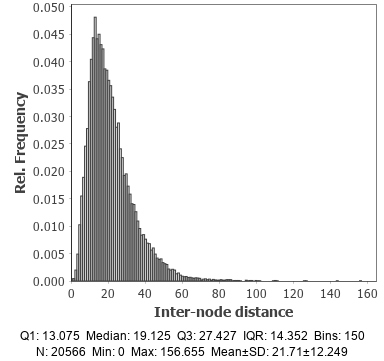

In [12]:
s_stats.getHistogram(metric).show()
# from IPython.display import Image, display
# display(Image(r'C:\Users\arshadic\Desktop\notebook_hist.png'))